# Working with PyWPH

This notebook introduces the functionalities of PyWPH, a Python package designed to compute Wavelet Phase Harmonic (WPH) statistics from images. This package makes use of PyTorch/CUDA, thus enabling GPU-accelerated computations as well as differentiable programming.

We first recall the definition of the WPH statistics, and then show how to compute these statistics from images. We also discuss some of their applications for generative modeling.

For additional details on the WPH statistics we refer to:

[\[1\]](https://arxiv.org/abs/2208.03538) Régaldo-Saint Blancard, B., Allys, E., Auclair, C., Boulanger, F., Eickenberg, M., Levrier, F., Vacher, L. & Zhang, S. (2022). Generative Models of Multi-channel Data from a Single Example - Application to Dust Emission. [arXiv:2208.03538](https://arxiv.org/abs/2208.03538).

## 1. PyWPH 101

### 1.0. Background

The WPH statistics rely on a set of bandpass and lowpass filters allowing to locally decompose the spectral content of the input maps onto a tiling of Fourier space. These filters are respectively wavelets and Gaussian filters. 

Here, we introduce the *WPH moments*, defined as covariances of nonlinear transformations of the wavelet transform of a given random field $X$. The nonlinear transformation is a pointwise operation called *phase harmonic*, which is defined below. Then, we introduce the *scaling moments*, defined in a similar fashion as the WPH moments but involving Gaussian filters instead of wavelets. The WPH statistics of a map $x$ refer to the estimates of the WPH moments and scaling moments.

#### Wavelets and wavelet transform

A wavelet is a spatially localized waveform with a zero mean which acts as a bandpass filter. From an initial wavelet $\psi$, called the *mother wavelet*, we build a bank of wavelets $\{\psi_{j, \theta}\}_{j, \theta}$ by dilation and rotation of $\psi$, where $j$ is an index of dilation and $\theta$ is an angle of rotation. Formally, we have:
$$
	\psi_{j, \theta}(\mathbf{r}) \propto \psi(2^{-j}R_{\theta}^{-1}\mathbf{r}).
$$
The number of dilations and rotations considered are $J$ and $L$, respectively, so that ${0 \leq j \leq J - 1}$ and ${\theta\in\{k\pi/L, 0\leq k \leq L - 1\} }$. Consequently, our bank of wavelets is made of $J\times L$ wavelets. In the following, we make use of bump-steerable wavelets. These are complex-valued wavelets defined in [\[1\]](https://arxiv.org/abs/2208.03538) (Appendix B.1.).

The wavelet transform of $X$ is finally defined as the set of bandpass-filtered maps $\{ X \ast \psi_{j, \theta}\}_{j, \theta}$, where $\ast$ denotes the convolution operation. These convolutions correspond to local bandpass filterings of $X$ at spatial frequencies centered on modes of the form $\mathbf{k}_{j,\theta} = k_02^{-j}\mathbf{u}_\theta$, with $\mathbf{u}_\theta=\cos\left(\theta\right)\mathbf{e}_x + \sin\left(\theta\right)\mathbf{e}_y$ and $k_0$ the central frequency of the mother wavelet $\psi$.

#### WPH moments

For a statistically homogeneous 2D random field $X$ (which can be either real or complex-valued), we introduce the WPH moments of $X$ as follows:
$$
C_{\lambda,p,\lambda^\prime,p^\prime}(\mathbf{\tau}) = \mathrm{Cov}\left(\left[X \ast \psi_\lambda(\mathbf{r})\right]^{p},\left[X \ast \psi_{\lambda^\prime}(\mathbf{r} + \mathbf{\tau})\right]^{p^\prime}\right),
$$
with $\lambda$ and $\lambda^\prime$ referring to two oriented scales $(j, \theta)$ and $(j^\prime, \theta^\prime)$, and the bracket denoting the pointwise phase harmonic operator $z \mapsto \left[z \right]^p = |z| \cdot \text{e}^{i p~\text{arg}(z)}$. We recall that ${\mathrm{Cov}(X,Y) = \mathrm{E}\left(\left(X - \mathrm{E}(X)\right)\overline{\left(Y - \mathrm{E}(Y)\right)}\right)}$. Note that these moments do not depend on the $\mathbf{r}$ variable because of the homogeneity of $X$. When applied to a complex $z$, the phase harmonic operator preserves the modulus of $z$ but multiplies its phase by a factor $p$. Note that, for $p=0$, this operation simply consists in taking the modulus of $z$, and for $p=1$ it is the identity. This operator plays a key role to capture efficiently interactions between different scales in $X$. For $\lambda = \lambda^\prime$ and $p = p^\prime = 1$, the corresponding moments are averages of the power spectrum over the bandpass of $\psi_\lambda$, so that this class of moments does include the power spectrum information. We give additional details on these moments below.

The previous moments all depend on the relative shift $\mathbf{\tau}$ between $X\ast \psi_\lambda$ and $X\ast \psi_{\lambda^\prime}$. We discretize this variable as follows:
$$
    \mathbf{\tau}_{n, \alpha} =
    \begin{cases}
    2^n\mathbf{u}_{\alpha} &\text{for $n \geq 1$},\\
    \mathbf{0} &\text{for $n = 0$},
    \end{cases}
$$
with $0 \leq n \leq \Delta_n - 1$ and ${\alpha\in \{\alpha_k = \frac{k\pi}{A}, 0\leq k \leq 2A-1\}}$, where $\Delta_n$ and $A$ are two integers playing similar roles to $J$ and $L$ but for $n$ and $\alpha$ variables instead of $j$ and $\theta$, respectively.

#### Scaling moments

To better constrain the large scales as well as the one-point distribution of the input fields, we introduce the scaling moments of $X$. These rely on a family of isotropic Gaussian filters $\{\varphi_j\}_{j}$ that are built by dilating an initial Gaussian function $\varphi$ (defined in [\[1\]](https://arxiv.org/abs/2208.03538), Appendix B.1.) similarly to what is done for wavelets. Assuming zero-mean $X$, our scaling moments are defined as follows:
$$
    L_{j, p, p^\prime} = \mathrm{Cov}\left(\left[X \ast \varphi_{j}(\mathbf{r})\right]^{p},\left[X \ast \varphi_{j}(\mathbf{r})\right]^{p^\prime}\right).
$$

Now let's dive into the code, and show how to compute these coefficients from images with PyWPH!

### 1.1. Basics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch

In [2]:
print(pw.__version__)
print(np.__version__)
print(torch.__version__)

1.1
1.21.2
2.0.0


Let's load and plot a first test image. Here we choose a real-valued image corresponding to a simulated intensity map of the diffuse interstellar medium. This image inherits from the periodic boundary conditions of the underlying simulation, and we expect strong non-Gaussian statistics since it's well known that the physics of the interstellar medium is highly nonlinear.

Data shape: (256, 256)


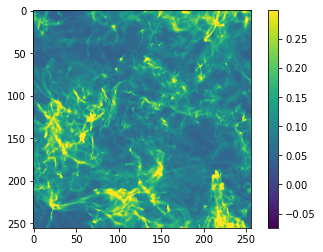

In [3]:
x = np.load('data/I_1.npy')[::2, ::2] # We lower the resolution of this image for performance.
print("Data shape:", x.shape)

plt.figure()
plt.imshow(x, vmin=x.mean() - 3*x.std(), vmax=x.mean() + 3*x.std())
plt.colorbar()
plt.show()

We call `M` and `N` the width and height of our image, respectively, and choose the number of scales `J` that we want to probe accordingly. We recall that a wavelet $\psi_{j, \theta}$ from our bank of wavelets is a dilated version of the mother wavelet $\psi$ where the dilation factor is $2^j$. With $j \in \{0, 1, \dots, J-1\}$, it's clear that `J` should roughly verify ${J \lessapprox \log_2(\min(M, N))}$. Here, we have $\log_2(\min(M, N)) = 8$ and we choose $J= 7$, choosing to probe an exhaustive range of scales in our data. We also choose the number `L` of rotation angles between $[0, \pi)$ (sometimes called $\Theta$ in the literature). Here, we pick a typical value of 4. Finally, for now we only want to consider moments for which $\tau = 0$, this can be achieved by setting $\Delta_n = 0$ (called `dn` in PyWPH).

In [4]:
M, N = x.shape
J = 7
L = 4
dn = 0

Once these modeling choices are made, we can compute in a quite straightforward way the WPH coefficients of our test image. We just need for that a `WPHOp` object, which represents the operator designed to compute WPH statistics for any given image of shape `(M, N)`.

In [5]:
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)

The computation of the WPH statistics is then straightforward:

In [6]:
stats = wph_op(x)

Alternatively, note that one could use the apply or forward method, which does exactly the same thing:

In [7]:
stats = wph_op.apply(x)
stats = wph_op.forward(x)

By default, these computations are performed on the CPU. However, one can easily run all of this on a GPU device (provided CUDA is available) by doing:

In [8]:
if torch.cuda.is_available():
    wph_op.to(0) # Select device 0

# Altenatively, one could have specified the target device at the definition of the WPHOp object with:
# wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)

When available, GPU acceleration is recommended for these computations.

### 1.2. Coefficients and WPH object

OK, so what do we have computed? Let's print the shape of the coefficients and take a look at the values of the first coefficients:

In [9]:
print(stats.shape)
print(stats[:10])

torch.Size([513])
tensor([3.8982e-05+0.j, 2.7234e-05+0.j, 2.2196e-05+0.j, 2.7308e-05+0.j, 6.0902e-05+0.j,
        4.8682e-05+0.j, 4.3545e-05+0.j, 5.3626e-05+0.j, 7.8910e-05+0.j, 6.3880e-05+0.j])


We remark two things. First, the returned `stats` variable is a `torch.Tensor` object with complex values. Although on this example the printed coefficients have a null imaginary part, in general, the WPH coefficients can be complex-valued (although some particular classes of coefficients are expected to be real-valued, see below). Second, here we have no information on the nature of the moments these coefficients are supposed to estimate.

To better understand what we have computed here, instead of just returning a plain `torch.Tensor` object, one can ask to return a `WPH` object. The `WPH` class is designed to ease the manipulation of the WPH coefficients. It facilitates the selection of a subset of coefficients, as well as their reduction. However, currently a `WPH` object stores the coefficients in a NumPy array, and thus does not rely on PyTorch anymore (which prevents differentiable programming or GPU acceleration).

To ask for a `WPH` object when computing the WPH statistics, we proceed as follows:

In [10]:
wph = wph_op(x, ret_wph_obj=True)

Now, let us only print the $S^{(11)}$ coefficients (analogous to band-averaged power spectra coefficients) and their respective indices:

In [11]:
s11, s11_indices = wph.get_coeffs("S11") # Select the S11 coefficients
print(s11.shape)
print(s11_indices)
print(s11)

(28,)
[[0 0 1 0 0 1 0 0 0]
 [0 1 1 0 1 1 0 0 0]
 [0 2 1 0 2 1 0 0 0]
 [0 3 1 0 3 1 0 0 0]
 [1 0 1 1 0 1 0 0 0]
 [1 1 1 1 1 1 0 0 0]
 [1 2 1 1 2 1 0 0 0]
 [1 3 1 1 3 1 0 0 0]
 [2 0 1 2 0 1 0 0 0]
 [2 1 1 2 1 1 0 0 0]
 [2 2 1 2 2 1 0 0 0]
 [2 3 1 2 3 1 0 0 0]
 [3 0 1 3 0 1 0 0 0]
 [3 1 1 3 1 1 0 0 0]
 [3 2 1 3 2 1 0 0 0]
 [3 3 1 3 3 1 0 0 0]
 [4 0 1 4 0 1 0 0 0]
 [4 1 1 4 1 1 0 0 0]
 [4 2 1 4 2 1 0 0 0]
 [4 3 1 4 3 1 0 0 0]
 [5 0 1 5 0 1 0 0 0]
 [5 1 1 5 1 1 0 0 0]
 [5 2 1 5 2 1 0 0 0]
 [5 3 1 5 3 1 0 0 0]
 [6 0 1 6 0 1 0 0 0]
 [6 1 1 6 1 1 0 0 0]
 [6 2 1 6 2 1 0 0 0]
 [6 3 1 6 3 1 0 0 0]]
[3.8981776e-05-9.1793088e-16j 2.7233811e-05+3.7035270e-15j
 2.2195965e-05-3.0867249e-15j 2.7307698e-05+1.0897082e-15j
 6.0902101e-05-1.3509784e-14j 4.8681755e-05+9.3687688e-15j
 4.3545435e-05-1.9651259e-14j 5.3626100e-05+1.5149072e-14j
 7.8910249e-05-2.2246033e-14j 6.3880158e-05+1.3056141e-14j
 6.5253320e-05+3.1021938e-14j 7.7161814e-05+1.0767977e-14j
 8.4692234e-05+2.7897250e-15j 6.6998327e-05+7.51751

The indices of the coefficients are given in the following order: $j$, $\theta$, $p$, $j^\prime$, $\theta^\prime$, $p^\prime$, $n$, $\alpha$, pseudo. For a definition of the "pseudo" index, see Sect. 3.

We can also select coefficients that have any prescribed index value. Let's select coefficients for which $j=0$ and $\theta=2$:

In [12]:
coeffs, coeffs_indices = wph.get_coeffs(j1=0, t1=2)
print(coeffs.shape)
print(coeffs_indices)
print(coeffs)

(33,)
[[ 0  2  0  0  2  0  0  0  0]
 [ 0  2  0  0  2  1  0  0  0]
 [ 0  2  0  1  0  1  0  0  0]
 [ 0  2  0  1  1  1  0  0  0]
 [ 0  2  0  1  2  1  0  0  0]
 [ 0  2  0  1  3  1  0  0  0]
 [ 0  2  0  2  0  1  0  0  0]
 [ 0  2  0  2  1  1  0  0  0]
 [ 0  2  0  2  2  1  0  0  0]
 [ 0  2  0  2  3  1  0  0  0]
 [ 0  2  0  3  0  1  0  0  0]
 [ 0  2  0  3  1  1  0  0  0]
 [ 0  2  0  3  2  1  0  0  0]
 [ 0  2  0  3  3  1  0  0  0]
 [ 0  2  0  4  0  1  0  0  0]
 [ 0  2  0  4  1  1  0  0  0]
 [ 0  2  0  4  2  1  0  0  0]
 [ 0  2  0  4  3  1  0  0  0]
 [ 0  2  0  5  0  1  0  0  0]
 [ 0  2  0  5  1  1  0  0  0]
 [ 0  2  0  5  2  1  0  0  0]
 [ 0  2  0  5  3  1  0  0  0]
 [ 0  2  0  6  0  1  0  0  0]
 [ 0  2  0  6  1  1  0  0  0]
 [ 0  2  0  6  2  1  0  0  0]
 [ 0  2  0  6  3  1  0  0  0]
 [ 0  2  1  0  2  1  0  0  0]
 [ 0  2  1  1  2  2  0  0  0]
 [ 0  2  1  2  2  4  0  0  0]
 [ 0  2  1  3  2  8  0  0  0]
 [ 0  2  1  4  2 16  0  0  0]
 [ 0  2  1  5  2 32  0  0  0]
 [ 0  2  1  6  2 64  0  0  0]]
[ 1

Note that, in PyWPH, $j$ and $j^\prime$ are called `j1` and `j2`, respectively. Similar notations are adopted for $\theta$ and $p$ variables.

Also keep in mind that for any PyWPH class/method, one can access to the documentation by using the `help` function.

In [13]:
help(wph.get_coeffs)

Help on method get_coeffs in module pywph.wph:

get_coeffs(clas='', j=None, p=None, j1=None, t1=None, p1=None, j2=None, t2=None, p2=None, n=None, a=None, sm=False, pseudo=None) method of pywph.wph.WPH instance
    Selection of coefficients.
    To select scaling moments coefficients use sm=True, otherwise select WPH coefficients.
    
    Parameters
    ----------
    clas : str, optional
        Class of coefficients. The default is "".
    j : int, optional
        DESCRIPTION. The default is None.
    p : int, optional
        DESCRIPTION. The default is None.
    j1 : int, optional
        DESCRIPTION. The default is None.
    t1 : int, optional
        DESCRIPTION. The default is None.
    p1 : int, optional
        DESCRIPTION. The default is None.
    j2 : int, optional
        DESCRIPTION. The default is None.
    t2 : int, optional
        DESCRIPTION. The default is None.
    p2 : int, optional
        DESCRIPTION. The default is None.
    n : int, optional
        DESCRIPTIO

### 1.3. Changing the model

By default, a `WPHOP` object computes the following classes of coefficients.

For the WPH moments:
* the $S^{(1,1)}$ moments, of the form $C_{\lambda,1,\lambda,1}(\mathbf{\tau}) = \mathrm{Cov}\left(X \ast \psi_{\lambda}(\mathbf{r}), X \ast \psi_{\lambda}(\mathbf{r} + \mathbf{\tau})\right)$, at every $\mathbf{\tau}_{n, \alpha}$. They measure weighted averages of the power spectrum over the bandpass of $\psi_\lambda$.
* the $S^{(0,0)}$ moments, of the form $C_{\lambda,0,\lambda,0}(\mathbf{\tau})= \mathrm{Cov}\left(|X \ast \psi_{\lambda}(\mathbf{r})|,|X \ast \psi_{\lambda}(\mathbf{r} + \mathbf{\tau})|\right)$, at every $\mathbf{\tau}_{n, \alpha}$. They capture information related to the sparsity of the data in the bandpass of $\psi_\lambda$.
* the $S^{(0,1)}$ moments, of the form $C_{\lambda,0,\lambda,1}(\mathbf{\tau}) = \mathrm{Cov}\left(|X \ast \psi_{\lambda}(\mathbf{r})|,X \ast \psi_{\lambda}(\mathbf{r} + \mathbf{\tau})\right)$, at $\mathbf{\tau} = 0$ only. They capture information related to the couplings between the scales included in the same bandpass.
* the $C^{(0,1)}$ moments, of the form $C_{\lambda,0,\lambda^\prime,1}(\mathbf{\tau}) = \mathrm{Cov}\left(|X \ast \psi_{\lambda}(\mathbf{r})|, X \ast \psi_{\lambda^\prime}(\mathbf{r} + \mathbf{\tau})\right)$, considering ${0 \leq j < j^\prime \leq J - 1}$, at every $\mathbf{\tau}_{n, \alpha}$ when $\theta = \theta^\prime$ and at $\mathbf{\tau} = 0$ only when $\theta \neq \theta^\prime$. They capture information related to the correlation between local levels of oscillation for the scales in the bandpasses associated with $\psi_{\lambda}$ and $\psi_{\lambda^\prime}$.
* the $C^{\rm phase}$ moments, of the form $C_{\lambda,1,\lambda^\prime, p^\prime}(\mathbf{\tau}) = \mathrm{Cov}\left(X \ast \psi_{\lambda}(\mathbf{r}), \left[X \ast \psi_{\lambda^\prime}(\mathbf{r} + \mathbf{\tau})\right]^{p^\prime}\right)$ with ${p^\prime = 2^{j^\prime - j} > 1}$, considering $0 \leq j < j^\prime \leq J - 1$ and $\theta = \theta^\prime$, at every $\mathbf{\tau}_{n, \alpha}$. They capture information related to the statistical phase alignment of oscillations between the scales in the bandpasses associated with $\psi_{\lambda}$ and $\psi_{\lambda^\prime}$.

For the scaling moments:
* $L_{j, 0, 0}$ moments, of the form $\mathrm{Cov}\left(|X \ast \varphi_{j}(\mathbf{r})|,|X \ast \varphi_{j}(\mathbf{r})|\right)$.
* $L_{j, 0, 1}$ moments, of the form $\mathrm{Cov}\left(|X \ast \varphi_{j}(\mathbf{r})|,X \ast \varphi_{j}(\mathbf{r})\right)$.
* $L_{j, 1, 1}$ moments, of the form $\mathrm{Cov}\left(X \ast \varphi_{j}(\mathbf{r}),X \ast \varphi_{j}(\mathbf{r})\right)$.

Currently, the default $j$ values that are taken into account to compute scaling moments are $j\in\{-1, \dots, \lfloor J/4 \rfloor \}$.

We call "model" a subset of these coefficients. If you want to change the default model associated with your `WPHOP` object, you can use the `WPHOp.load_model` method.

In [14]:
 # From now on, we only want to compute S11, S01, and C01 coefficients.
wph_op.load_model(["S11", "S01", "C01"])

wph = wph_op(x, ret_wph_obj=True) # This object only contains S11, S01, and C01 coefficients

### 1.4. Visualization of a few coefficients

Now, let's take a look at the $S^{(11)}$ and $S^{(01)}$ coefficients we have just computed:

/tmp/ipykernel_2122064/3761724149.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


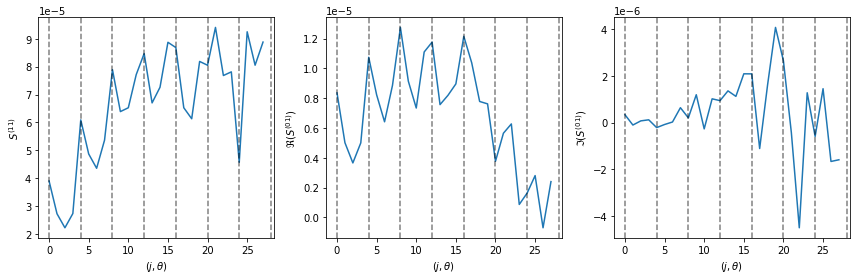

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(wph.get_coeffs("S11")[0].real)
axs[1].plot(wph.get_coeffs("S01")[0].real)
axs[2].plot(wph.get_coeffs("S01")[0].imag)

axs[0].set_xlabel(r'$(j, \theta)$')
axs[1].set_xlabel(r'$(j, \theta)$')
axs[2].set_xlabel(r'$(j, \theta)$')
axs[0].set_ylabel(r'$S^{(11)}$')
axs[1].set_ylabel(r'$\Re(S^{(01)})$')
axs[2].set_ylabel(r'$\Im(S^{(01)})$')

for j in range(J + 1):
    axs[0].axvline(j*L, linestyle='dashed', color='black', alpha=0.5)
    axs[1].axvline(j*L, linestyle='dashed', color='black', alpha=0.5)
    axs[2].axvline(j*L, linestyle='dashed', color='black', alpha=0.5)

fig.tight_layout()
fig.show()

The $S^{(11)}$ and $S^{(01)}$ coefficients we have computed here are indexed by two variables $j$ and $\theta$ only. By default, these are sorted in a lexicographical order according to $(j, \theta)$. Since we have picked $L=4$ earlier, this means that $j$ increases by one for each block of 4 coefficients. The vertical dashed lines split the coefficients according to their $j$ value. Note that, for a given $j$ value, we observe variations of the coefficients as a function of $\theta$. This is particularly clear for low $j$ values on the $S^{(11)}$ and $\Re(S^{(01)})$. This indicates a form of statistical anisotropy in the data.

The $C^{(01)}$ coefficients, which quantify interactions between two oriented scales $(j, \theta)$ and $(j^\prime, \theta^\prime)$, are obviously much more difficult to visualize since they depend on four different indices. They are also usually much more numerous than any class of $S$ coefficients.

/tmp/ipykernel_2122064/203343410.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


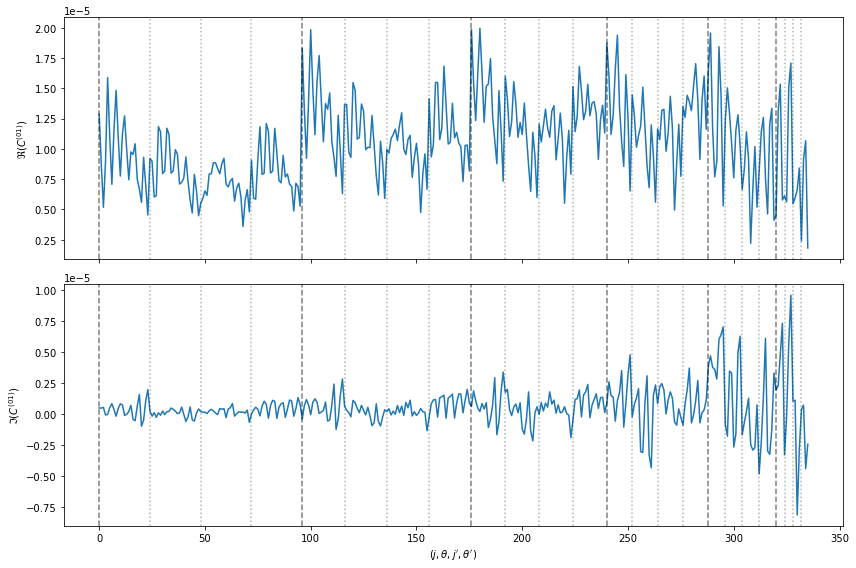

In [16]:
c01, c01_indices = wph.get_coeffs("C01")

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(c01.real)
axs[1].plot(c01.imag)

axs[1].set_xlabel(r'$(j, \theta, j^\prime, \theta^\prime)$')
axs[0].set_ylabel(r'$\Re(C^{(01)})$')
axs[1].set_ylabel(r'$\Im(C^{(01)})$')

j1_cnt, t1_cnt, tot_cnt = -1, -1, 0
for index in c01_indices:
    if index[0] > j1_cnt:
        axs[0].axvline(tot_cnt, linestyle='dashed', color='black', alpha=0.5)
        axs[1].axvline(tot_cnt, linestyle='dashed', color='black', alpha=0.5)
        j1_cnt += 1
        t1_cnt = 0
    if index[1] > t1_cnt:
        axs[0].axvline(tot_cnt, linestyle='dotted', color='black', alpha=0.3)
        axs[1].axvline(tot_cnt, linestyle='dotted', color='black', alpha=0.3)
        t1_cnt += 1
    tot_cnt += 1

fig.tight_layout()
fig.show()

The vertical dashed lines here delimit coefficients of constant $(j, \theta)$ value.

### 1.5. Normalization

The default behavior of a `WPHOp` object is to compute unnormalized coefficients. However, some applications of the WPH statistics may require a relevant normalization of these coefficients. One usual way to do this, and that has been proven effective for WPH-based generative models (see Sect. 2.), is to define normalized estimates of the WPH moments and scaling moments as follows:
$$
\begin{align}
    \tilde{C}_{\lambda,p,\lambda^\prime,p^\prime}(\mathbf{\tau}) &= \frac{\big \langle x^{(\lambda, p)}\left(\mathbf{r}\right)\overline{x^{(\lambda^\prime, p^\prime)}}\left(\mathbf{r}+\mathbf{\tau}\right)\big \rangle}{\sqrt{\big \langle |{x_0^{(\lambda, p)}}|^2\big \rangle\big \langle|{x_0^{(\lambda^\prime, p^\prime)}}|^2\big \rangle}},\\
    \tilde{L}_{j,p, p^\prime} &= \frac{ \langle x^{(j,p)}x^{(j,p^\prime)} \rangle}{\sqrt{\langle |x_0^{(j,p)}|^2 \rangle\langle |x_0^{(j,p^\prime)}|^2 \rangle}},
\end{align}
$$
where the brackets stand for a spatial mean on $\mathbf{r}$, and ${x^{(\mathbf{\xi}, p)} = [x \ast \psi_{\mathbf{\xi}}]^{p} - \big \langle [x_0 \ast \psi_{\mathbf{\xi}})]^{p}\big \rangle}$. These normalized coefficients depend on a reference $x_0$ that needs to be specified.

To compute normalized coefficients as defined previously, we just need to add the flag `norm='auto'` when computing WPH statistics with our `wph_op` object. But before that, we first have to choose a reference map. Here, we pick another test intensity map of the diffuse interstellar medium.

In [17]:
x0 = np.load('data/I_2.npy')[::2, ::2]

Our `WPHOp` object will use as a reference map the first map for which we compute WPH statistics with the flag `norm='auto'`. Internally, our `wph_op` object will keep in memory the coefficients needed to normalize any other WPH statistics computed in the future using the flag `norm='auto'`.

In [18]:
wph_op(x0, norm='auto'); # This line keeps in memory what is needed to normalized WPH coefficients using x0 as a reference map

Now we can compute the normalized coefficients of `x` as follows:

In [19]:
stats_norm = wph_op(x, norm='auto')

# These coefficients are normalized
print(stats_norm[:10])

tensor([1.1644+3.9206e-10j, 0.9615+7.5611e-11j, 0.9384-2.1488e-10j,
        1.1057-2.2879e-10j, 1.0324-1.0416e-10j, 0.8434-1.2686e-10j,
        0.9702-1.0234e-10j, 1.1092-1.9663e-10j, 0.9788-6.7557e-11j,
        0.7643-1.7772e-10j], device='cuda:0')


/mnt/home/bregaldosaintblancard/Tools/pywph/pywph/pywph/wph_operator.py:803: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 = xpsi1_k1 - mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


Note that unnormalized coefficients depend on the normalization chosen to define our filters (wavelets or Gaussian filters). Using `norm='auto'`, the normalized WPH coefficients do not depend anymore on the normalization of the filters.

If one wants to compute normalized coefficients using another reference map, one just has to first clear what has been stored in the `wph_op` object regarding the previous reference map by doing:

In [20]:
wph_op.clear_normalization()

## 2. Generative models with PyWPH

One can use the WPH statistics of a single map $x$ to define a generative model for which samples, a.k.a. *syntheses*, share strong visual and statistical similarities with the original map $x$ for a variety of non-Gaussian data. This kind of model is called a microcanonical gradient descent model in the literature (see [Bruna \& Mallat 2019](https://arxiv.org/abs/1801.02013) and [Zhang \& Mallat 2021](https://arxiv.org/abs/1911.10017)). It is an approximation of a maximum entropy microcanonical model conditioned by WPH statistics.

Samples of the model are drawn by iteratively deforming an initial Gaussian white noise into a map that has the same WPH statistics as $x$. Formally, calling $\phi(x)$ the WPH statistics of $x$, the sampling procedure consists in minimizing the following loss function:
$$
\mathcal{L}(y) = \lVert \phi(y) - \phi(x) \rVert^2,
$$
where $\lVert \cdot \rVert$ is the Euclidean norm, and the optimizer is initialized with a Gaussian white noise.

In this section, we use the [SciPy LBFGS optimizer](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) by providing exact gradients of the objective computed using PyTorch automatic differentiation. If you have no idea of what automatic differentiation is, first take a look at [this introduction](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html).

### 2.1. Computing $\nabla \mathcal{L}(y)$

Automatic differentation allows us to compute the exact gradient of the objective function $\mathcal{L}$ evaluated at a given input $y$. To do that, we first need to define a `torch.Tensor` object containing $y$ that has the attribute `requires_grad` set to `True`. On this example, let's take $y=x$.

In [21]:
y_torch = torch.from_numpy(x.astype(np.float32))
if torch.cuda.is_available():
    y_torch = y_torch.to(0)
y_torch.requires_grad = True

Now, to compute $\nabla \mathcal{L}(y)$ we can proceed as follows:

In [22]:
x_coeffs = wph_op(x) # We recompute the coefficients of x

# Compute the coefficients and the gradient of the loss by accumulating gradients of loss chunks
y_torch, nb_chunks = wph_op.preconfigure(y_torch) # Preconfiguration and chunk splitting
coeffs = []
for i in range(nb_chunks):
    print(f"{i + 1}/{nb_chunks}")
    y_coeffs_chunk, indices = wph_op(y_torch, i, ret_indices=True)
    loss_chunk = (torch.absolute(y_coeffs_chunk - x_coeffs[indices]) ** 2).sum()
    loss_chunk.backward(retain_graph=True)
    coeffs.append(y_coeffs_chunk.detach().cpu())
    del y_coeffs_chunk, loss_chunk # To free GPU memory
coeffs = torch.cat(coeffs, -1)
grad = y_torch.grad

1/2
2/2


Because WPH computations can have an important memory cost, we have to compute the WPH coefficients of $y$ as well as the gradient of the objective $\mathcal{L}$ chunk by chunk. In Sect. 1. we had not to think about the memory cost of the computations since this chunk splitting was handled internally, but here, because we also need to compute the gradient of $\mathcal{L}$, we have to explicitly deal with this chunk splitting.

In the previous piece of code, `wph_op.preconfigure` automatically estimates the number of chunks needed so that our computation fits on the available memory of the current device. Then, for each chunk, we compute the corresponding coefficients associated with $y$. The flag `ret_indices=True` asks to also return an array of indices allowing us to retrieve the corresponding coefficients associated with $x$ that were previously computed. The variable `loss_chunk` corresponds to a chunk of the total loss $\mathcal{L}$. The `backward` method, which computes the gradient of the current loss chunk, is called with the  flag `retain_graph=True` because of the way the computation of the WPH statistics may be optimized internally. Sucessive calls of the `backward` method sums gradient chunks into `y_torch.grad` attribute.

Note that this chunk splitting trick is possible because our objective function can be written:
$$
\mathcal{L}(y) = \sum_{k=0}^{N_{\rm chunks} - 1} \mathcal{L}_k(y)= \sum_{k=0}^{N_{\rm chunks} - 1}\lVert \phi_k(y) - \phi_k(x) \rVert^2,
$$
where $\mathcal{L}_k(y) = \lVert \phi_k(y) - \phi_k(x) \rVert^2$ and $\phi_k$ denotes the operator that computes the $k$-th chunk of WPH coefficients. Indeed, with such an additive decomposition, we also have:
$$
\nabla\mathcal{L}(y) = \sum_{k=0}^{N_{\rm chunks} - 1}\nabla\mathcal{L}_k(y).
$$

### 2.2. Optimization

Now that we have a clearer idea on how to compute the gradient of our objective, let's build our first synthesis with prescribed statistics $\phi(x)$.

Let's start by normalizing our target map $x$, and build a new WPH operator with the default model and slightly more relevant parameters.

In [23]:
# Normalize input data
x_norm = np.log10(x)
x_norm = (x_norm - x_norm.mean())/x_norm.std()

# Choice of the device
device = "cpu"
if torch.cuda.is_available():
    device = 0

# Redefine WPH operator
wph_op = pw.WPHOp(M, N, J, L=L, dn=5, device=device)

We generate an initial Gaussian seed `y0`, and compute the target coefficients $\phi(x)$. Here, we choose to normalize the coefficients using the `'auto'` mode, the reference map being $x$.

In [24]:
y0 = np.random.normal(x_norm.mean(), x_norm.std(), x_norm.shape)

x_coeffs = wph_op.apply(x_norm, norm='auto')
print(x_coeffs.shape)

torch.Size([6113])


Now we have all the material needed to run our favorite optimizer! Here what the optimization might look like with [SciPy LBFGS optimizer](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html):

In [25]:
import time
import scipy.optimize as opt

eval_cnt = 0

def objective(y):
    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    
    # Reshape y
    y_curr = y.reshape((M, N))
    
    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)
    y_curr, nb_chunks = wph_op.preconfigure(y_curr, requires_grad=True)
    for i in range(nb_chunks):
        y_coeffs_chunk, indices = wph_op.apply(y_curr, i, norm='auto', ret_indices=True)
        loss = torch.sum(torch.abs(y_coeffs_chunk - x_coeffs[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del y_coeffs_chunk, indices, loss
    
    # Reshape the gradient
    y_grad = y_curr.grad.cpu().numpy().astype(y.dtype)
    
    print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
    eval_cnt += 1
    return loss_tot.item(), y_grad.ravel()

result = opt.minimize(objective, y0.ravel(), method='L-BFGS-B', jac=True, tol=None, options={"maxiter": 50, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
final_loss, y_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
y_final = y_final.reshape(y0.shape)
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")

Evaluation: 0
Loss: 43577.9296875 (computed in 0.12s)
Evaluation: 1
Loss: 42715.09765625 (computed in 0.10s)
Evaluation: 2
Loss: 39410.75390625 (computed in 0.10s)
Evaluation: 3
Loss: 28349.373046875 (computed in 0.11s)
Evaluation: 4
Loss: 9451.40234375 (computed in 0.13s)
Evaluation: 5
Loss: 4155.43896484375 (computed in 0.11s)
Evaluation: 6
Loss: 1645.0479736328125 (computed in 0.11s)
Evaluation: 7
Loss: 733.6036987304688 (computed in 0.10s)
Evaluation: 8
Loss: 395.9530944824219 (computed in 0.10s)
Evaluation: 9
Loss: 259.35064697265625 (computed in 0.10s)
Evaluation: 10
Loss: 184.12815856933594 (computed in 0.10s)
Evaluation: 11
Loss: 109.15343475341797 (computed in 0.10s)
Evaluation: 12
Loss: 174.4965057373047 (computed in 0.10s)
Evaluation: 13
Loss: 68.1130142211914 (computed in 0.10s)
Evaluation: 14
Loss: 49.76460266113281 (computed in 0.10s)
Evaluation: 15
Loss: 29.328805923461914 (computed in 0.10s)
Evaluation: 16
Loss: 21.248985290527344 (computed in 0.10s)
Evaluation: 17
Loss

Let's finally take a look at our synthesis!

/tmp/ipykernel_2122064/2098050829.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


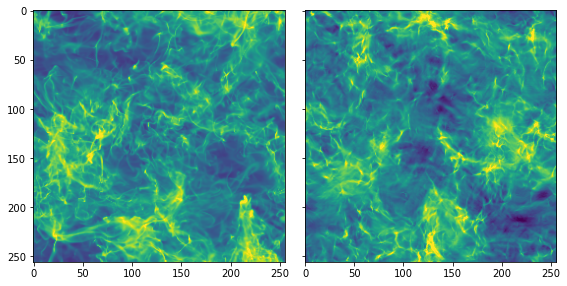

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
axs[0].imshow(x_norm, vmin=x_norm.mean() - 3*x_norm.std(), vmax=x_norm.mean() + 3*x_norm.std())
axs[1].imshow(y_final, vmin=x_norm.mean() - 3*x_norm.std(), vmax=x_norm.mean() + 3*x_norm.std())
fig.tight_layout()
fig.show()

## 3. Advanced functionalities

### 3.1. WPH statistics for complex-valued data

### 3.2. Refined tweaking of the model

### 3.3. Reduction of the WPH coefficients

### 3.4. Cross-WPH statistics